# G05 Tùy biến định dạng nội dung

## Mục đích

Trong bài này chúng ta sẽ tìm hiểu những tùy chỉnh về định dạng của các hình vẽ trong biểu đồ.


## Giới thiệu lại về màu sắc, hình dáng, và đường nét

Ba đặc tính về định dạng thường được điều chỉnh nhiều nhất là màu sắc, hình dáng của chấm, và đường nét của đường thẳng. Trong [bài đầu tiên của chương này](./01_intro.ipynb) mình đã giới thiệu sơ bộ cách thức định dạng bằng đối số `fmt` của hàm `plot()`. Chúng ta còn có thể sử dụng những đối số khác cho riêng từng đặc tính.

### Màu sắc

Đối với các biểu đồ sử dụng chấm, bạn có thể tùy chỉnh màu sắc của chúng bằng đối số `color` hay viết tắt là `c`. Xem thêm cách gọi màu sắc ở [đây](https://matplotlib.org/stable/tutorials/colors/colors.html).

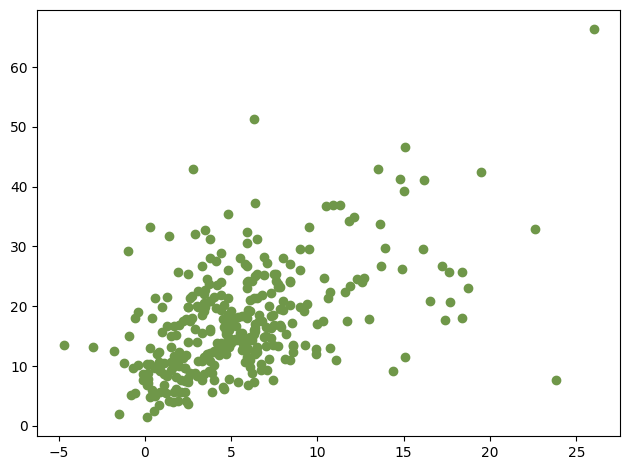

In [1]:
import pandas as pd

sex_labels = ["Nữ", "Nam"]
sex_dict = dict(zip(range(2), sex_labels))

eso_vtq_dict = {0: "Không VTQ", 1: "VTQ LA A", 2: "VTQ LA B", 3: "VTQ LA C"}

tuoi_nhom_labels = ["<30", "30-<40", "40-<50", "50+"]
tuoi_nhom_dict = dict(zip(range(1, 5), tuoi_nhom_labels))

d = pd.read_excel("../assets/hrm.xlsx") \
    .replace({
        "sex": sex_dict,
        "eso_LA": eso_vtq_dict
    }) \
    .assign(
        tuoi = lambda x: x["date_exam"].dt.year - x["yob"],
        sex = lambda x: pd.Categorical(x["sex"], categories=sex_labels, ordered=True),
    )

d["tuoi_nhom"] = 1 + d["tuoi"].ge(30) + d["tuoi"].ge(40) + d["tuoi"].ge(50)
d["tuoi_nhom"] = pd.Categorical(d["tuoi_nhom"].map(tuoi_nhom_dict),
    categories=tuoi_nhom_labels, ordered=True)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(tight_layout=True)
ax.scatter(d["les_irp4s"], d["les_baserestp"], c="#6f9749")
plt.show()

Như ví dụ vẽ theo nhóm trong [bài trước](./04_label.ipynb), chúng ta thấy rằng Matplotlib sẽ tự động chọn màu cho các nhóm có label khác nhau. Lí do Matplotlib làm được như vậy là do nó tự động quay vòng màu trong bảng màu (gọi là colormaps, xem ở [đây](https://matplotlib.org/stable/gallery/color/colormap_reference.html) và [đây](https://matplotlib.org/stable/tutorials/colors/colormaps.html)). Mặc định, Matplotlib sử dụng bảng màu "tab10", gồm có 10 màu trong bảng màu cơ bản của Tableau. Sau khi quay vòng hết 10 màu này, nhóm thứ 11 sẽ được sử dụng lại màu đầu tiên trong bảng màu.

Bạn có thể lựa chọn bảng màu khác cho hình vẽ của mình bằng đối số `cmap`. Để `cmap` có tác dụng, bạn cần cung cấp mã màu cụ thể trong bảng màu. Ví dụ, chúng ta muốn sử dụng màu trong bảng "Dark2" để thể hiện các nhóm viêm thực quản.

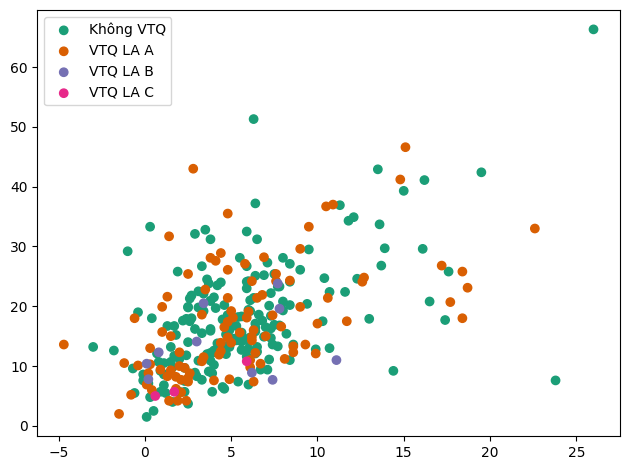

In [2]:
d_grpby = d.groupby("eso_LA")
n = len(d_grpby.groups)

fig, ax = plt.subplots(tight_layout=True)

for i, group in enumerate(d_grpby.groups):
    data = d_grpby.get_group(group)
    ax.scatter(data["les_irp4s"], data["les_baserestp"], label=group,
        c=[i] * data.shape[0], vmin=0, vmax=7, cmap="Dark2")

ax.legend()
plt.show()

Ở ví dụ trên đây bạn sẽ thấy có một vài điểm đáng chú ý:

* Mình dùng hàm `enumerate()` để lấy số thứ tự của từng nhóm viêm thực quản.
* Thay vì cung cấp một mã màu, chúng ta phải cung cấp một danh sách các màu (màu sắc tương ứng cho từng chấm).
* Chúng ta xác định hai đối số là `vmin` và `vmax`. Chúng là khoảng giá trị (min, max) của mã màu để Matplotlib chuyển đổi mã màu trong `c` (có thể là 1, 2, 3, 4) về đoạn [0, 1], và từ đó ứng lên bảng màu để chọn màu phù hợp. Ở đây, bảng màu "Dark2" có 8 màu rời rạc, và vì chúng ta đánh số các nhóm bắt đầu 0, chúng ta sẽ chọn khoảng giá trị của mã màu là từ 0 đến 7. Như vậy, Matplotlib sẽ lấy 4 màu đầu tiên (0, 0.125, 0.25, và 0.375) trong bảng màu "Dark2".

Trong trường hợp không cần label, bạn có thể tô màu mà không cần dùng đến `groupby()`. Chúng ta sẽ sử dụng thuộc tính `codes` của kiểu dữ liệu categorical trong Pandas để lấy số thứ tự các nhóm (hoặc bạn có thể giữ nguyên code của cột `"eso_LA"`, không replace như ban đầu chúng ta đã làm). Ở điểm này, rõ ràng là Matplotlib không linh hoạt bằng `ggplot2` của R.

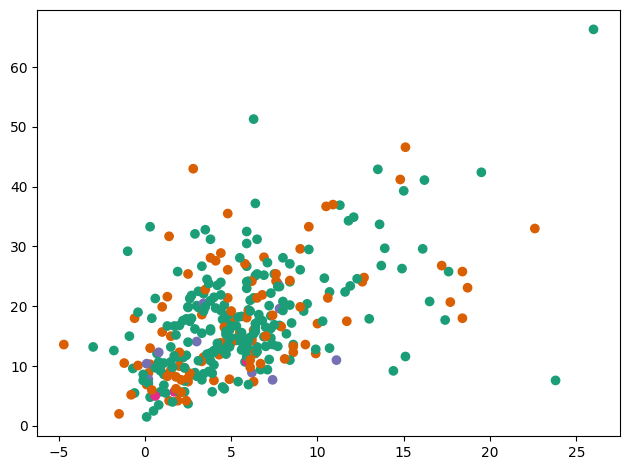

In [3]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter("les_irp4s", "les_baserestp", data=d,
    c=d["eso_LA"].astype("category").cat.codes, vmin=0, vmax=7, cmap="Dark2")
plt.show()

#### Độ trong suốt (alpha)

Ở biểu đồ trên, chúng ta thấy các chấm có vẻ bị "dính" vào nhau, nhìn không được rõ. Chúng ta có thể làm cho chúng trở thành "nửa trong suốt" để nhìn rõ hơn. Bạn có thể điều chỉnh độ trong suốt bằng cách thay đổi giá trị của kênh alpha (chấp nhận các giá trị từ 0 đến 1).

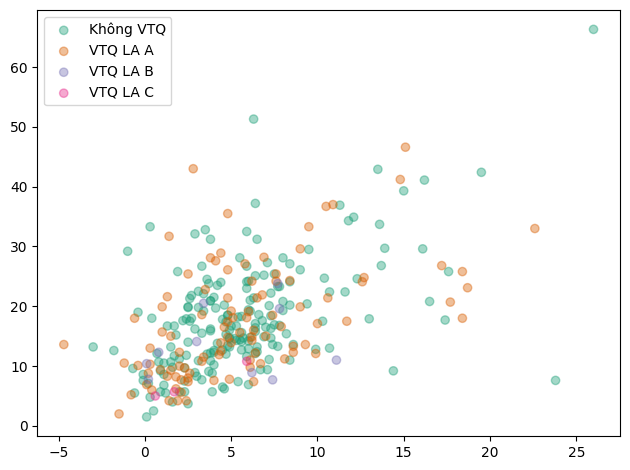

In [4]:
d_grpby = d.groupby("eso_LA")
n = len(d_grpby.groups)

fig, ax = plt.subplots(tight_layout=True)

for i, group in enumerate(d_grpby.groups):
    data = d_grpby.get_group(group)
    ax.scatter(data["les_irp4s"], data["les_baserestp"], label=group,
        c=[i] * data.shape[0], vmin=0, vmax=7, cmap="Dark2",
        alpha=0.4)

ax.legend()
plt.show()

#### Màu viền (edge color)

Mặc dù các chấm đã nhìn rõ hơn, bạn có thể thấy rằng mỗi chấm đều có một viền đậm màu hơn. Đối số `edgecolor` hay `ec` cho phép bạn hay đổi màu sắc, hoặc thậm chí loại bỏ nó (bằng cách đặt là `None` hoặc `"none"`).

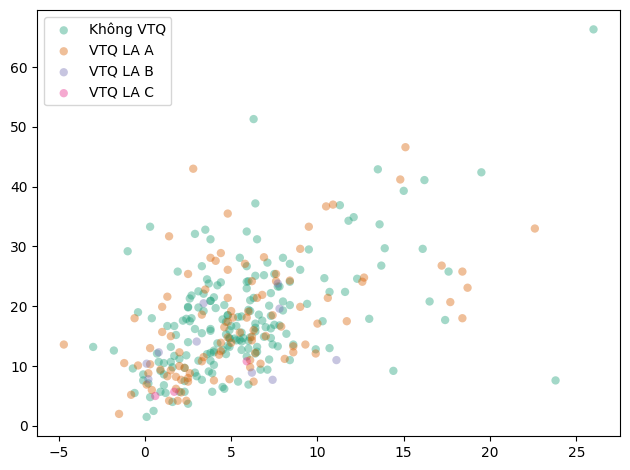

In [5]:
d_grpby = d.groupby("eso_LA")
n = len(d_grpby.groups)

fig, ax = plt.subplots(tight_layout=True)

for i, group in enumerate(d_grpby.groups):
    data = d_grpby.get_group(group)
    ax.scatter(data["les_irp4s"], data["les_baserestp"], label=group,
        c=[i] * data.shape[0], vmin=0, vmax=7, cmap="Dark2",
        alpha=0.4, ec=None)

ax.legend()
plt.show()

Các hàm đồ họa khác nhau sẽ có thể có một số đối số về màu sắc khác (ví dụ, hàm vẽ các đường thẳng dọc hoặc ngang như `Axes.hlines()` và `Axes.vlines()` dùng đối số `colors`, hay `Axes.errorbar()` có thêm đối số `ecolor` để thiết lập màu cho đoạn thẳng). Khi nào cần dùng đến các công cụ này thì bạn tự tìm hiểu trong documentation của Matplotlib nhé.


### Hình dáng và đường nét

Hai vấn đề này thì đơn giản hơn màu sắc, vì chúng có kí hiệu quy định cho từng hình dáng, đường nét cụ thể, và bạn chỉ cần cung cấp thông tin cho Matplotlib thôi. Với hình dáng của chấm, bạn cung cấp thông qua đối số `marker`, với đường nét cho đường thẳng, bạn cung cấp thông qua đối số `linestyle` hay `ls`.

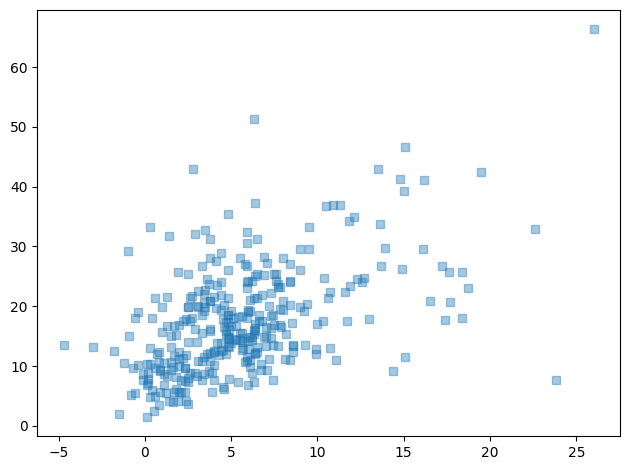

In [6]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter("les_irp4s", "les_baserestp", data=d,
    marker="s", alpha=0.4)
plt.show()

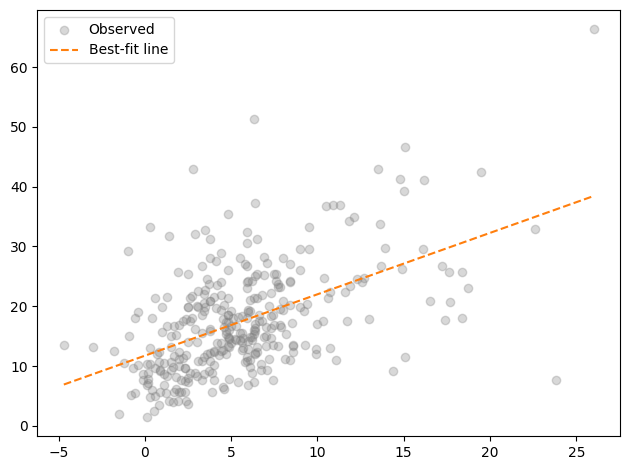

In [7]:
# Mô phỏng seaborn.regplot()
import statsmodels.api as sm

model = sm.OLS.from_formula("les_baserestp ~ les_irp4s", data=d)
fit = model.fit()
x_min, x_max = d["les_irp4s"].agg(["min", "max"])
yhat_min, yhat_max = fit.predict({"les_irp4s": [x_min, x_max]})

fig, ax = plt.subplots(tight_layout=True)
ax.scatter("les_irp4s", "les_baserestp", data=d, c="gray", alpha=.3, label="Observed")
ax.plot([x_min, x_max], [yhat_min, yhat_max], c="C1", ls="--", label="Best-fit line")
ax.legend()
plt.show()

## Quay vòng định dạng

Trong một số trường hợp, bạn muốn các nhóm khác nhau có các màu sắc, hình dáng, và đường nét khác nhau. Chẳng hạn, bạn đang tổng hợp IRP 4s trung vị theo nhóm tuổi, và muốn giữa hai nhóm nam và nữ không chỉ có màu khác nhau, mà nam sẽ là hình tròn, nữ là hình tam giác, và đường kẻ của nam sẽ là đường kẻ đứt. Bạn có thể cân nhắc quay vòng định dạng như trong ví dụ dưới đây.

In [8]:
d_agg = d.groupby(["sex", "tuoi_nhom"])["les_irp4s"] \
    .agg("median").reset_index()
d_agg

,sex,tuoi_nhom,les_irp4s
0,Nữ,<30,5.05
1,Nữ,30-<40,5.90
2,Nữ,40-<50,4.90
3,Nữ,50+,5.60
4,Nam,<30,4.30
5,Nam,30-<40,4.40
6,Nam,40-<50,2.50
7,Nam,50+,5.05


Chú ý rằng trước khi tổng hợp số liệu, mình đã chuyển các biến danh mục trở thành kiểu [categorical có thứ hạng](../04_data/15_categorical.ipynb) (thiết lập `ordered=True`). Điều này sẽ đảm bảo bạn biết chắc chắn nhóm nào sẽ sử dụng định dạng nào.

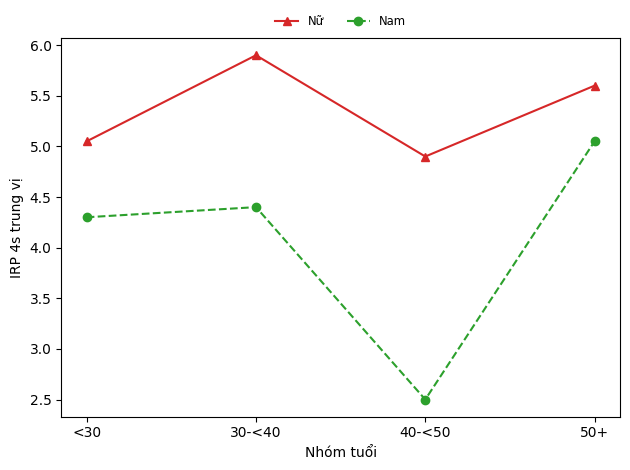

In [9]:
sex_colors = ["C3", "C2"]
sex_linestyles = ["-", "--"]
sex_markers = ["^", "o"]

d_grpby = d_agg.groupby("sex")

fig, ax = plt.subplots(tight_layout=True)

for i, group in enumerate(d_grpby.groups):
    data = d_grpby.get_group(group)
    ax.plot("tuoi_nhom", "les_irp4s", data=data, label=group,
        c=sex_colors[i], marker=sex_markers[i], ls=sex_linestyles[i])

ax.set_xlabel("Nhóm tuổi")
ax.set_ylabel("IRP 4s trung vị")
ax.legend(frameon=False, fontsize="small", ncols=2, loc="lower center", bbox_to_anchor=[0.5, 1])
plt.show()

Trong trường hợp không sử dụng kiểu categorical, bạn vẫn có thể quy định được nhóm nào dùng định dạng nào nhờ từ điển. Nếu đã quên cách xây dựng từ điển như dưới đây, xem lại bài [I01](../02_inter/01_zipenum.ipynb) nhé.

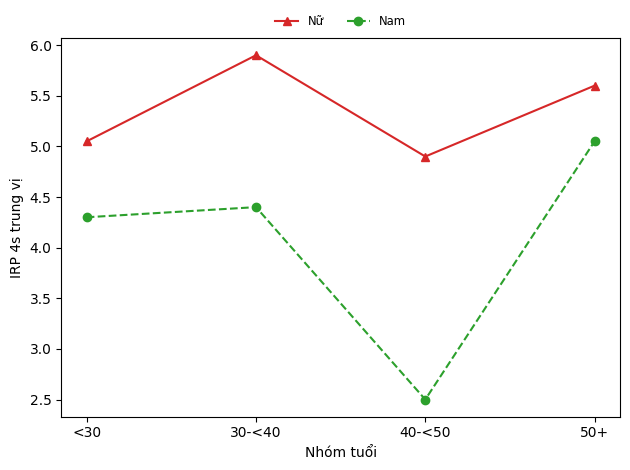

In [10]:
sex_colors = ["C3", "C2"]
sex_linestyles = ["-", "--"]
sex_markers = ["^", "o"]

sexes = ["Nữ", "Nam"]

sex_colors_dict = dict(zip(sexes, sex_colors))
sex_linestyles_dict = dict(zip(sexes, sex_linestyles))
sex_markers_dict = dict(zip(sexes, sex_markers))

d_grpby = d_agg.groupby("sex")

fig, ax = plt.subplots(tight_layout=True)

for group in d_grpby.groups:
    data = d_grpby.get_group(group)
    ax.plot("tuoi_nhom", "les_irp4s", data=data, label=group,
        c=sex_colors_dict[group], marker=sex_markers_dict[group], ls=sex_linestyles_dict[group])

ax.set_xlabel("Nhóm tuổi")
ax.set_ylabel("IRP 4s trung vị")
ax.legend(frameon=False, fontsize="small", ncols=2, loc="lower center", bbox_to_anchor=[0.5, 1])
plt.show()

---

[Bài trước](./04_label.ipynb) - [Danh sách bài](../README.md) - [Bài sau](./06_axis.ipynb)